In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import gzip
import joblib
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from urllib.request import urlopen
import time
import itertools
from itertools import islice, cycle
from more_itertools import pairwise
from tqdm.auto import tqdm
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import mean_average_precision_at_k
from scipy.sparse.linalg import svds
from pandas.api.types import CategoricalDtype
import scipy.sparse as sp
import math
from sklearn.metrics import mean_squared_error
# pip install implicit

import warnings
warnings.filterwarnings("ignore")

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

## Description:
Amazon is a famous E-commerce website with millions of products. To suggest customers the most relevant items Amazon uses item-to-item Collaborative Filtering Recommender System.   

Product category used in this project: CDS and Vinyl. This dataset contains product ratings from users spanning May 1996 - July 2014.

Data collection: http://jmcauley.ucsd.edu/data/amazon/links.html


Dataframe contains 4 features:

- user_id - user unique identificator
- product_id - product unique identificator
- rating - user's evaluation of a product on a scale from 1 to 5
- timestamp - when user rated product


## Goal:

Build Recommender Models to recommend products to users based on their ratings and find similar items in catalogue.

## Tasks:

1. Explore dataset.
2. Take a subset of the dataset to make it denser.
3. Preprocess data: split into train and test datasets.
4. Build Popularity Recommender model.
5. Build Collaborative Filtering recommendation sysyem (item-item and user-user approaches).
6. Evaluate models with RMSE and NDCG

In [3]:
# Read the csv file and assign column names
rdata = pd.read_csv("D:/jupyter/pymagic/e-commerce RecSys/ratings_CDs_and_Vinyl.csv",
                    names=['user_id', 'product_id', 'rating', 'timestamp'])

In [4]:
rdata

,user_id,product_id,rating,timestamp
0,A9DMTMLFR9CO5,0001393774,5.0,1377907200
1,AHG1GTQZUYNJN,0001393774,5.0,1372723200
2,A2TFO7NREP2B2D,0001393774,5.0,1396396800
3,A2YAPAG1IPNK7K,0001393774,5.0,1392422400
4,AEKGGV851HY3K,0001393774,5.0,1130803200
...,...,...,...,...
3748999,A122G17YDFX176,B00LG9GR3S,5.0,1405382400
3749000,A26QVK35BBBKU8,B00LG9GR3S,5.0,1404777600
3749001,A1V76VMZ0N3H5W,B00LG9GR3S,5.0,1404864000
3749002,A248BRA9BLBUJ2,B00LH0CAT6,5.0,1404518400


In [5]:
# Check the data info and datatypes
rdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3749004 entries, 0 to 3749003
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   user_id     object 
 1   product_id  object 
 2   rating      float64
 3   timestamp   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 114.4+ MB


In [6]:
# Check missing data
rdata.isnull().sum()
# No missing values in df

user_id       0
product_id    0
rating        0
timestamp     0
dtype: int64

In [7]:
# Count users and products in dataframe
unique_users = len(np.unique(rdata.user_id))
unique_pdts = len(np.unique(rdata.product_id))
print(f'Number of users in dataset: {unique_users}')
print(f'Number of products in dataset: {unique_pdts}')

Number of users in dataset: 1578597
Number of products in dataset: 486360


In [8]:
# Set threshold 20 for users to make dataset less sparse
df_user = rdata[rdata.groupby('user_id')['user_id'].transform('size') >= 20]
df_user

,user_id,product_id,rating,timestamp
4,AEKGGV851HY3K,0001393774,5.0,1130803200
6,A12R54MKO17TW0,0001393774,5.0,1326067200
49,A3JAIZQ5RS064X,0307141144,5.0,993600000
54,A2AOZQ3WTNVVOK,030714142X,3.0,1143676800
65,A3IEV6R2B7VW5Z,0307141985,5.0,1128556800
...,...,...,...,...
3748919,A1B621EA66Z8KV,B00L326LTI,5.0,1405814400
3748951,A3UKLX2A9T589C,B00L326LTI,5.0,1405468800
3748974,ASEBX8TBYWQWA,B00L5MGHLI,4.0,1404950400
3748977,A1TR2CQMTNMC56,B00L5SFSN0,1.0,1405641600


In [9]:
# Set threshold 20 for items to make dataset less sparse
df_item = df_user[df_user.groupby(
    'product_id')['product_id'].transform('size') >= 20]
df_item

,user_id,product_id,rating,timestamp
1446,A2K3LZPH3ND94V,0780018664,4.0,1167868800
1448,AQS3Z062MTX0L,0780018664,1.0,1015200000
1449,A1GSR7RGCG1QYZ,0780018664,5.0,1249344000
1455,A2GANR9I6XHTU9,0780018664,4.0,1169337600
1457,ANCOMAI0I7LVG,0780018664,5.0,1213574400
...,...,...,...,...
3747245,AXHWQ834G3IUV,B00K5T1LZ4,5.0,1402963200
3747257,A182SY7I1OPU3A,B00K5T1LZ4,5.0,1405296000
3747268,AVN00ASBFTMN6,B00K5T1LZ4,3.0,1404518400
3747278,A3VAXB8CDYY5BG,B00K5T1LZ4,2.0,1402963200


In [10]:
# count how many ratings were given by every user
ratings_per_user = df_item.groupby(by='user_id')['rating'].count(
).sort_values(ascending=False).to_frame().reset_index()
ratings_per_user = ratings_per_user.rename(
    {'rating': 'user_rating_counter'}, axis=1)
ratings_per_user

,user_id,user_rating_counter
0,A9Q28YTLYREO7,1182
1,A3KJ6JAZPH382D,946
2,A8IFUOL8S9BZC,744
3,A2582KMXLK2P06,743
4,A26NLSTT75FMJM,716
...,...,...
14124,A1OP0NTJ1SOXKF,1
14125,A337V5X9P34IE3,1
14126,A1ORZKYPMHLRUC,1
14127,A2JD1IORKB585I,1


In [11]:
# merge counter to dataframe
df = df_item.merge(ratings_per_user, on="user_id", how='inner')
df

,user_id,product_id,rating,timestamp,user_rating_counter
0,A2K3LZPH3ND94V,0780018664,4.0,1167868800,2
1,A2K3LZPH3ND94V,B000001FOD,4.0,1162512000,2
2,AQS3Z062MTX0L,0780018664,1.0,1015200000,1
3,A1GSR7RGCG1QYZ,0780018664,5.0,1249344000,7
4,A1GSR7RGCG1QYZ,B00005OAJ1,5.0,1120694400,7
...,...,...,...,...,...
273312,A2S0TMR69SMGC8,B00G5JCFEE,5.0,1394755200,1
273313,A2WD67QE1B6K95,B00HHYEOV8,5.0,1397865600,1
273314,A1FFRNXFNY1UG8,B00HHYEOV8,5.0,1397001600,1
273315,A26DDRSI90CWS,B00I0O9QJY,5.0,1398729600,1


In [12]:
# subset of users with more than 20 ratings
df_fin_u = df[(df['user_rating_counter'] >= 20).groupby(
    df['user_id']).transform('any')]
df_fin_u

,user_id,product_id,rating,timestamp,user_rating_counter
10,A2GANR9I6XHTU9,0780018664,4.0,1169337600,38
11,A2GANR9I6XHTU9,1573300403,5.0,1073520000,38
12,A2GANR9I6XHTU9,B000000GPY,5.0,1052006400,38
13,A2GANR9I6XHTU9,B000000IVW,5.0,1078963200,38
14,A2GANR9I6XHTU9,B000000OSG,5.0,1079568000,38
...,...,...,...,...,...
273122,A24PMZJF0LHGCW,B00B4VXQC8,5.0,1363046400,29
273123,A24PMZJF0LHGCW,B00B69UQEO,5.0,1364256000,29
273124,A24PMZJF0LHGCW,B00BHRCD14,5.0,1365465600,29
273125,A24PMZJF0LHGCW,B00DAPOHWE,5.0,1401148800,29


In [13]:
# count how many ratings each product gets
product_sum_ratings = df_fin_u.groupby(by='product_id')['rating'].count(
).sort_values(ascending=False).to_frame().reset_index()
product_sum_ratings = product_sum_ratings.rename(
    {'rating': 'product_rating_counter'}, axis=1)
product_sum_ratings

,product_id,product_rating_counter
0,B000000IRB,316
1,B00008OWZG,307
2,B000002UAT,276
3,B000000IV0,274
4,B000002UB2,274
...,...,...
6503,B001BWQVW2,1
6504,B000GLKLCK,1
6505,B000001GYJ,1
6506,B00BSO2U1Y,1


In [14]:
# merge item counter to df
df_fin = df_fin_u.merge(product_sum_ratings, on="product_id", how='inner')
df_fin

,user_id,product_id,rating,timestamp,user_rating_counter,product_rating_counter
0,A2GANR9I6XHTU9,0780018664,4.0,1169337600,38,21
1,ANCOMAI0I7LVG,0780018664,5.0,1213574400,177,21
2,A1GGOC9PVDXW7Z,0780018664,5.0,1268524800,64,21
3,A62G4QX6XQVLP,0780018664,5.0,1165190400,51,21
4,A2XKQHB8VCUCJK,0780018664,5.0,1385942400,27,21
...,...,...,...,...,...,...
190051,A2AIMXT9PLAM12,B000001G53,5.0,1127865600,25,2
190052,A328S9RN3U5M68,B00004TEUZ,5.0,1024444800,28,2
190053,A2AIMXT9PLAM12,B00004TEUZ,5.0,1128124800,25,2
190054,A37BJRKQPQ7Y54,B000GLKLCK,5.0,1276819200,24,1


In [15]:
df_fin.nunique()

user_id                   3713
product_id                6508
rating                       5
timestamp                 5741
user_rating_counter        250
product_rating_counter     173
dtype: int64

In [16]:
# transfrom timestamp to get year of rating
df_fin['timestamp'] = pd.to_datetime(
    df['timestamp'], unit='s', errors='coerce').dt.year
df_fin

,user_id,product_id,rating,timestamp,user_rating_counter,product_rating_counter
0,A2GANR9I6XHTU9,0780018664,4.0,2007,38,21
1,ANCOMAI0I7LVG,0780018664,5.0,2006,177,21
2,A1GGOC9PVDXW7Z,0780018664,5.0,2002,64,21
3,A62G4QX6XQVLP,0780018664,5.0,2009,51,21
4,A2XKQHB8VCUCJK,0780018664,5.0,2005,27,21
...,...,...,...,...,...,...
190051,A2AIMXT9PLAM12,B000001G53,5.0,2005,25,2
190052,A328S9RN3U5M68,B00004TEUZ,5.0,2006,28,2
190053,A2AIMXT9PLAM12,B00004TEUZ,5.0,2006,25,2
190054,A37BJRKQPQ7Y54,B000GLKLCK,5.0,2006,24,1


In [17]:
# mean rating of products
df_fin.groupby('product_id')['rating'].mean().sort_values(ascending=True)

product_id
B000BKSITO    1.178571
B0009ZE91M    1.210526
B000G04RLM    1.291667
B000IU3YLY    1.324324
B0000CD5F1    1.450000
                ...   
B000001FCK    5.000000
B000060P5O    5.000000
B000001F8N    5.000000
B00000A1GL    5.000000
B000002SO0    5.000000
Name: rating, Length: 6508, dtype: float64

# EDA

#### Hypothesis:
1. Rating distribution
2. High items quality: mean rating of a product will be between 3.5 and 5 
3. How frequently users rate products and amount of loyal customers 
4. When most ratings were given: either 2002-2006 (peak era for CDs and Vinyl + distribution of online retail) or 2006-2014 (more music releases and Amazon accessibility)
5. Relationship between average rating and number of evaluations

##### 1. Rating distribution

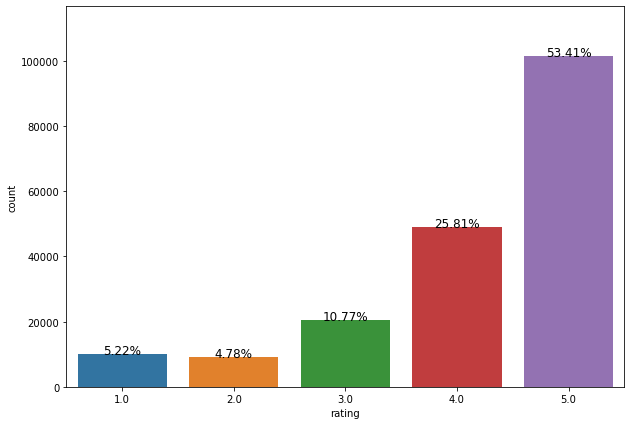

In [18]:
total = len(df_fin)
plt.figure(figsize=(10, 7))
pl = sns.countplot(df_fin['rating'])

sizes = []

for p in pl.patches:
    height = p.get_height()
    sizes.append(height)
    pl.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format((height/total)*100),
            ha="center", fontsize=12)

pl.set_ylim(0, max(sizes) * 1.15)

plt.show()

Over 50% of ratings are 5.0. Users are mostly satisfied with purchased product.

1/3 of buyers drag down max rating. 

There are 10% negative ratings explained by quality of record or delievery problems etc. 

##### 2. High items quality: mean rating of a product will be between 3.5 and 5 

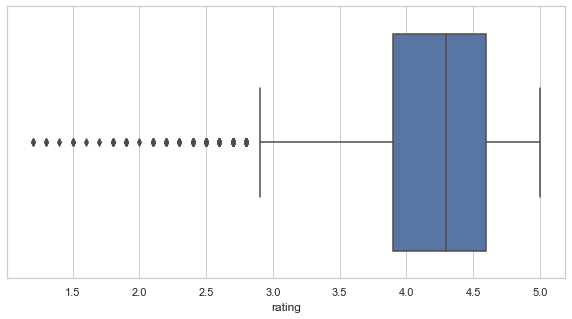

In [19]:
# items' mean rating
mean_rating = df_fin[['product_id', 'rating']].groupby(
    'product_id').mean().sort_values('rating').round(1)
plt.figure(figsize=(10, 5))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=mean_rating['rating'])
plt.show()

Average rating of Amazon items in category Vinyl and CDs is approximately 4.3. 

It can be explained by great quality of products, fast delievery, original and limited editions etc.
However, several outliers with lower score still present.

##### 3. How frequently users rate products and amount of loyal customers 

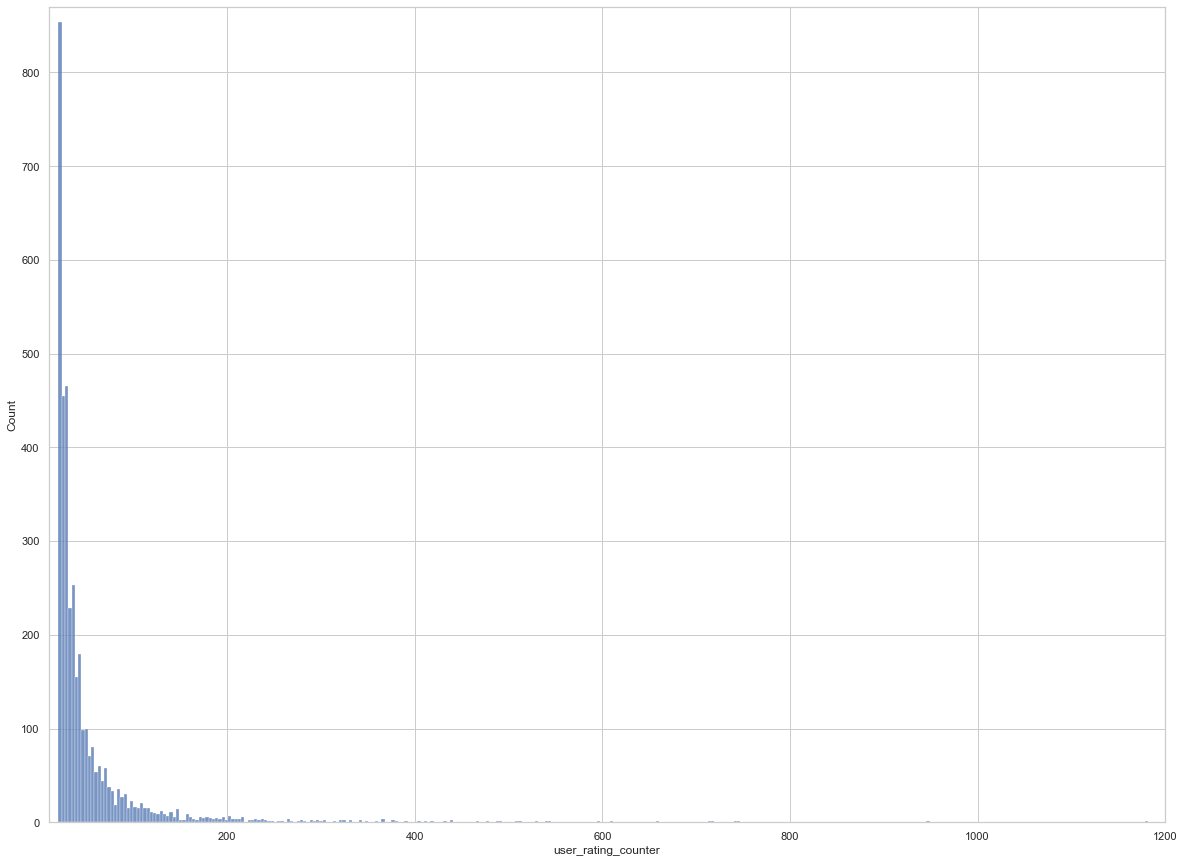

In [20]:
# number of users rating
us_r = df_fin[['user_id', 'user_rating_counter']].drop_duplicates(
    'user_id').sort_values(by='user_rating_counter', ascending=True)

plt.figure(figsize=(20, 15))
sns.set_theme(style="whitegrid")
ax = sns.histplot(x=us_r.user_rating_counter, stat='count')
ax.set(ylim=(0, 870))
ax.set(xlim=(10, 1200))

plt.show()

Vast majority of users rated less than 100 items (main segment).

Among regular customers most have 100-200 purchaces. A few bought 200-600 products. The maximum ratings in sample dataframe per user is 1182.

##### 4. When most ratings were given: either 2002-2006 (peak era for CDs and Vinyl + distribution of online retail) or 2006-2014 (more music releases and Amazon accessibility)

<AxesSubplot:xlabel='timestamp', ylabel='count'>

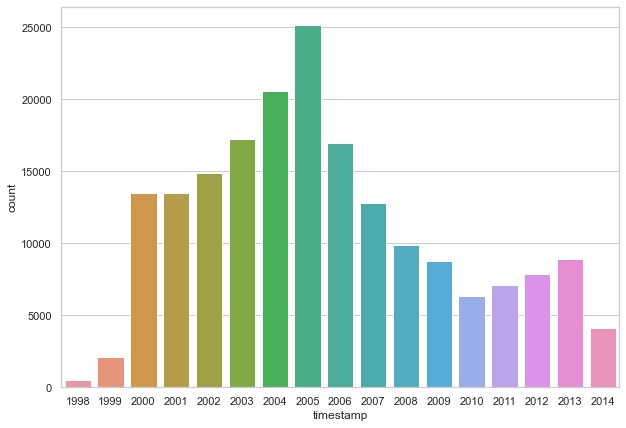

In [21]:
# count ratings per year
plt.figure(figsize=(10, 7))
sns.countplot(df_fin['timestamp'])

Peak year for ratings is 2005. Overall, period from 2002 to 2006 contains most ratings. 

Probably after that other platforms for buying and distribution of music were created + 2014 is the start of streaming era. 

2014 has less ratings compared to 2010s because not full year counted in dataframe, 1998-1999 is still developing of Amazon and Internet shopping is not so spread yet.

##### 5. Relationship between average rating and number of evaluations

In [22]:
data_grouped = df_fin[['product_id', 'rating']].groupby(
    'product_id').mean().reset_index()
df_grouped = data_grouped.merge(
    df_fin[['product_id', 'product_rating_counter']].drop_duplicates('product_id'), how='inner')
df_grouped

,product_id,rating,product_rating_counter
0,0780018664,4.809524,21
1,0780607287,4.714286,14
2,0788806270,4.757576,33
3,078881172X,4.730769,26
4,0790729350,4.548387,31
...,...,...,...
6503,B00J7UL6V6,4.250000,16
6504,B00JDB4PEY,4.037037,27
6505,B00JDB4PLM,4.230769,13
6506,B00JXETVRC,4.304348,23


<Figure size 1080x720 with 0 Axes>

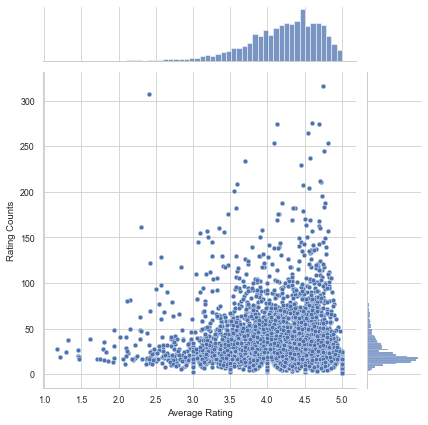

In [23]:
plt.figure(figsize=(15, 10))
sns.set_context('paper')
ax = sns.jointplot(x="rating", y='product_rating_counter',
                   kind='scatter',  data=df_grouped)
ax.set_axis_labels("Average Rating", "Rating Counts")
plt.show()

Poor items (Rating: 1-2.5) rarely get purchased and reviewed more than 50 times. 
Among popular products (>150 ratings) only 2 outliers, on average mean rating more than 3/5.

Area with 4+ rating denser and contains more popular and reviewed products as well.

# Data preprocessing

In [24]:
# Split data into train/test sapmles based on rating year
test_date = df_fin.sort_values('timestamp')['timestamp'].unique()[-4:]
test_date

array([2011, 2012, 2013, 2014], dtype=int64)

In [25]:
# Train: records with ratings in range 1998-2010. Test: records with ratings from 2011 to 2014
split_date = test_date[0]
X_train = df_fin[df_fin['timestamp'] < split_date]
X_test = df_fin[df_fin['timestamp'] >= split_date]
X_train.shape, X_test.shape

((162062, 6), (27994, 6))

In [26]:
# Split df into 85/15
X_test.shape[0]/(X_train.shape[0]+X_test.shape[0])

0.14729342930504694

In [27]:
def get_csr_matrix(data):
    """
    Create a sparse matrix in csr format to save memory.

    Parameters
    ----------
    data: dataframe with columns = ['user_id', 'product_id', 'ratings']
    ------
    """
    users_cat = CategoricalDtype(sorted(data.user_id.unique()), ordered=True)
    product_cat = CategoricalDtype(
        sorted(data.product_id.unique()), ordered=True)

    row = data.user_id.astype(users_cat).cat.codes
    col = data.product_id.astype(product_cat).cat.codes
    sparse_matrix = csr_matrix((data["rating"]/5, (row, col)),
                               shape=(users_cat.categories.size, product_cat.categories.size))

    return sparse_matrix


def from_sparse_format(sparse_matrix, data):
    """
    Generate analogue of pivot table from sparse matrix. 

    Parameters
    ----------
    sparse_matrix: sp.matrix, as (users x items) 
    data: dataframe with columns = ['user_id', 'product_id', 'ratings']
    ----------
    """
    users_cat = CategoricalDtype(sorted(data.user_id.unique()), ordered=True)
    product_cat = CategoricalDtype(
        sorted(data.product_id.unique()), ordered=True)

    dfs = pd.DataFrame.sparse.from_spmatrix(sparse_matrix,
                                            index=users_cat.categories,
                                            columns=product_cat.categories)
    return dfs

In [28]:
df_m = from_sparse_format(get_csr_matrix(df_fin), df_fin)
df_m

,0780018664,0780607287,0788806270,078881172X,0790729350,1573300403,1858704553,1858705223,1858705231,1929243154,...,B00I0O9QJY,B00IIT0CHG,B00IIUAPCM,B00IQE4NUK,B00IWS73PW,B00J7UL6V6,B00JDB4PEY,B00JDB4PLM,B00JXETVRC,B00K5T1LZ4
A08161909WK3HU7UYTMW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1020L7BWW9RAX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1031R8HD3E4GL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A103KNDW8GN92L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A103W7ZPKGOCC9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZSN1TO0JI87B,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZTZ61W23JET0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZVA13Q19KURR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZVH70JMJ2IHX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# create dict of enumerate items in dataframe and inverse dict
items_inv_mapping = dict(enumerate(df_m.columns.unique()))
items_mapping = {v: k for k, v in items_inv_mapping.items()}
print(f'No of products: {len(items_mapping)}')
items_inv_mapping

No of products: 6508


{0: '0780018664',
 1: '0780607287',
 2: '0788806270',
 3: '078881172X',
 4: '0790729350',
 5: '1573300403',
 6: '1858704553',
 7: '1858705223',
 8: '1858705231',
 9: '1929243154',
 10: '5555991584',
 11: '5557530584',
 12: '5558160063',
 13: '5558783532',
 14: '5559291986',
 15: '630025075X',
 16: '6300251020',
 17: '6300270424',
 18: '6300273199',
 19: '6301095294',
 20: '6302213142',
 21: '6302238064',
 22: '6302250056',
 23: '630237250X',
 24: '6302372666',
 25: '6302415993',
 26: '6302775205',
 27: '6302869390',
 28: '6303047564',
 29: '6303058760',
 30: '6303152775',
 31: '6303206204',
 32: '6303234844',
 33: '6303284183',
 34: '6303286542',
 35: '6303303463',
 36: '6303314015',
 37: '6303329071',
 38: '6303337023',
 39: '6303459765',
 40: '6303477259',
 41: '6304235682',
 42: '6304479689',
 43: '6304639457',
 44: '6305131147',
 45: '6305180261',
 46: '6305268177',
 47: '6305459525',
 48: '6305603871',
 49: '6305610444',
 50: '6305846464',
 51: '6305910022',
 52: '7799623519',
 53

In [30]:
# create dict of enumerate users in dataframe and inverse dict
users_inv_mapping = dict(enumerate(df_m.index.unique()))
users_mapping = {v: k for k, v in users_inv_mapping.items()}
print(f'No of users: {len(users_mapping)}')
users_mapping

No of users: 3713


{'A08161909WK3HU7UYTMW': 0,
 'A1020L7BWW9RAX': 1,
 'A1031R8HD3E4GL': 2,
 'A103KNDW8GN92L': 3,
 'A103W7ZPKGOCC9': 4,
 'A105S56ODHGJEK': 5,
 'A105YVLAZNYQUU': 6,
 'A1065Q31DNPRAN': 7,
 'A107R79K63CE30': 8,
 'A10872FHIJAKKD': 9,
 'A10BYR4GN1D86N': 10,
 'A10DK4W3I14H14': 11,
 'A10DNCYK7YISHU': 12,
 'A10EICDA6FL5VK': 13,
 'A10I9Y44HCRPG': 14,
 'A10ID9PBP48AXN': 15,
 'A10IDVD9INU6FP': 16,
 'A10JF2S8V3HYD4': 17,
 'A10KCGSDJJAVRO': 18,
 'A10LDRKHO99AY6': 19,
 'A10M94ASQEBL56': 20,
 'A10TCQ0SBQU50Y': 21,
 'A10TCTBISG95NU': 22,
 'A10WOHX7AOZ8MU': 23,
 'A10XJR7CWHNKWU': 24,
 'A10XU1ERL5JPV8': 25,
 'A10Y0CLCJ1L4LA': 26,
 'A10Y1BZ88EJO63': 27,
 'A10ZD0AOC1BPOM': 28,
 'A10ZSSZO3BO11Z': 29,
 'A110AP71Q2CS1R': 30,
 'A110LZFBUFYWN7': 31,
 'A111K82VQPY91M': 32,
 'A1134JYIL2MGZW': 33,
 'A1140GVQQ2AJ17': 34,
 'A1143SNKOV0ZIT': 35,
 'A117RJ6J5CO53D': 36,
 'A11BC4PIHPZVJP': 37,
 'A11C3BT4A8M9VG': 38,
 'A11CNSUROWGLEG': 39,
 'A11D1KHM7DVOQK': 40,
 'A11ED8O95W2103': 41,
 'A11EKP8L073NEY': 42,
 'A11H85UYL2R4KX

# Popularity based Recommender model

Non-personalised type of recommender systems. Can be a simple solution for new users with no history ('cold start problem'). This model recommends all users the same N items based on number of product ratings. 

## Basic Popularity Model

In [31]:
# get mean rating of each product in train sample
data_grouped_tr = X_train[['product_id', 'rating']
                          ].groupby('product_id').mean().reset_index()
data_grouped_tr

,product_id,rating
0,0780018664,4.809524
1,0780607287,4.692308
2,0788806270,4.692308
3,078881172X,4.730769
4,0790729350,4.548387
...,...,...
6314,B00J7UL6V6,4.250000
6315,B00JDB4PEY,3.636364
6316,B00JDB4PLM,4.230769
6317,B00JXETVRC,4.363636


In [32]:
# merge with rate counter of each product_id and descending sorting
df_grouped_tr = X_train[['product_id', 'product_rating_counter']].drop_duplicates(
    'product_id').merge(data_grouped_tr, how='inner', on='product_id')
# Basic popularity model
df_grouped_tr.sort_values(by='product_rating_counter', ascending=False)

,product_id,product_rating_counter,rating
342,B000000IRB,316,4.745342
1096,B00008OWZG,307,2.411552
208,B000002UAT,276,4.652941
211,B000002UB2,274,4.690840
349,B000000IV0,274,3.855422
...,...,...,...
6232,B000001GYJ,1,5.000000
6311,B000060P5O,1,5.000000
6047,B001BWQVW2,1,5.000000
6317,B000GLKLCK,1,5.000000


In [33]:
# Set and print N recommendations = 10
N_recommendations = 10
popularity_model = df_grouped_tr.sort_values(
    by=['product_rating_counter', 'rating'], ascending=[0, 0])
# Choose product with rating >= 4
popularity_model = popularity_model[popularity_model['rating'] >= 4]
popularity_model.head(N_recommendations)

,product_id,product_rating_counter,rating
342,B000000IRB,316,4.745342
208,B000002UAT,276,4.652941
211,B000002UB2,274,4.690840
209,B000002UAX,265,4.528958
207,B000002UAR,254,4.818182
462,B000002H97,254,4.084848
309,B000002H33,245,4.705128
313,B000002J09,237,4.579439
560,B00004ZAV3,230,4.464646
475,B000002JS6,212,4.693989


Assign rank to products from popularity model

In [34]:
# Generate a recommendation rank based upon score
popularity_model['rank'] = popularity_model['product_rating_counter'].rank(
    ascending=0, method='first')
popularity_model
# Get the top 10 recommendations
ranking_recommendations = popularity_model.head(10)
ranking_recommendations

,product_id,product_rating_counter,rating,rank
342,B000000IRB,316,4.745342,1.0
208,B000002UAT,276,4.652941,2.0
211,B000002UB2,274,4.690840,3.0
209,B000002UAX,265,4.528958,4.0
207,B000002UAR,254,4.818182,5.0
462,B000002H97,254,4.084848,6.0
309,B000002H33,245,4.705128,7.0
313,B000002J09,237,4.579439,8.0
560,B00004ZAV3,230,4.464646,9.0
475,B000002JS6,212,4.693989,10.0


In [35]:
def recommendations_popular(als_model, csr_train):
    """
    Generate dataframe with N recommendations for each user

    Parameters
    ----------
    als_model: AlternatingLeastSquares with tuned params
    csr_train: sparse matrix as (users x items)
    ----------
    """
    preds = []
    batch_size = 50
    to_generate = np.arange(len(users_mapping))
    for startidx in range(0, len(to_generate), batch_size):
        batch = to_generate[startidx: startidx + batch_size]
        ids, scores = als_model.recommend(
            batch, csr_train[batch], N=10, filter_already_liked_items=True)
        for i, userid in enumerate(batch):
            user_id = users_inv_mapping[userid]
            user_items = ids[i]
            article_ids = [items_inv_mapping[item_id]
                           for item_id in user_items]
            preds.append((user_id, ' '.join(article_ids)))

    df_preds = pd.DataFrame(preds, columns=['user_id', 'prediction'])

    print(f'Recommendations for users:')

    return df_preds

In [36]:
def recommendation(user_ID, N_recommendations):
    """
    user_ID: str, ID of user 
    N_recommendations: int, top n recommendations
    """
    user_recommendations = popularity_model.head(N_recommendations)

    cols = user_recommendations.columns.tolist()
    user_recommendations = user_recommendations[cols]

    return user_recommendations

In [37]:
# generate sample of users' id to demostrate same non-personalised recommendations
users = X_train['user_id'].sample(n=3).tolist()

for i in users:
    print(f"Here is recommendations for user: {i}")
    print(recommendation(i, 10))
    print("\n")

Here is recommendations for user: A1J5KCZC8CMW9I
     product_id  product_rating_counter    rating  rank
342  B000000IRB                     316  4.745342   1.0
208  B000002UAT                     276  4.652941   2.0
211  B000002UB2                     274  4.690840   3.0
209  B000002UAX                     265  4.528958   4.0
207  B000002UAR                     254  4.818182   5.0
462  B000002H97                     254  4.084848   6.0
309  B000002H33                     245  4.705128   7.0
313  B000002J09                     237  4.579439   8.0
560  B00004ZAV3                     230  4.464646   9.0
475  B000002JS6                     212  4.693989  10.0


Here is recommendations for user: A398Z0ZU011ILU
     product_id  product_rating_counter    rating  rank
342  B000000IRB                     316  4.745342   1.0
208  B000002UAT                     276  4.652941   2.0
211  B000002UB2                     274  4.690840   3.0
209  B000002UAX                     265  4.528958   4.0
207 

### Evaluation

DCG:
![DCG](https://lh4.googleusercontent.com/zA6ypnbEED9XOtheukjRqB5gYAftKvU29KiPUk-AwL9EQXkFZSCyIht0wKwY4WQxbzcv_EbtAXcT86AODXWQ_IShQKhgGcnLBdrwakrKzaxapuGwkb4R1Aw7Vez4P5GbELW3MawRqnM)
NDCG:
![NDCG](https://lh5.googleusercontent.com/Vw1V56DgbbYjdezCVkoon5LGj9xsRJsWum0TECdoN1Vcj4UBkR66cBfVvA_Yy842ws27oy4UZq_r0xsLy7DEB62wfIYTLf_YKW9qd5B8nZCPdMrDNiIjmaBv0NwscSfVoJBSYJwUgxQ)

In [38]:
# Calculating the RMSE of the popularity based recommendation system
# Rating present in the test data is the actual rating
data_tt = X_test
data_tt = data_tt[['user_id', 'product_id', 'rating']]
data_tt.rename(columns={'rating': 'act_rating'}, inplace=True)
data_tt

,user_id,product_id,act_rating
50,A2ZDXPKUF80H5H,B000000GPY,5.0
78,A10JF2S8V3HYD4,B000000GPY,5.0
118,AKGF27HN0OF19,B000000IVW,5.0
121,A2TSHD7SWDGS58,B000000IVW,5.0
145,A3QZ8WR4DD1ZOS,B000000IVW,5.0
...,...,...,...
189988,A200C7YQJ45LRR,B00004YL8S,3.0
189990,A1UH3S1GVFSMFH,B00004YL8S,4.0
190001,AZD7NEVKD2GBX,B0000C23D6,1.0
190003,A2DQL2TQLGUVG,B0000C23D6,1.0


In [39]:
# Merge the train data having average rating with the test data having actual rating at product level
data_tr_tt = pd.merge(
    popularity_model[['product_id', 'rating']], data_tt, on='product_id', how='inner')
data_tr_tt

,product_id,rating,user_id,act_rating
0,B000000IRB,4.745342,A2C7BOQVFH1HLE,5.0
1,B000000IRB,4.745342,A16CZRQL23NOIW,5.0
2,B000000IRB,4.745342,A1VXN0LM7NUQ3L,5.0
3,B000000IRB,4.745342,A1WYIDGR8ZG21X,5.0
4,B000000IRB,4.745342,AZSN1TO0JI87B,5.0
...,...,...,...,...
16845,B000SQJ2X2,4.000000,A2U4PLAUZQOSCH,5.0
16846,B000003G8G,5.000000,AKT8TGIT6VVZ5,5.0
16847,B000003G8G,5.000000,AUDSM2CTLLW1Q,5.0
16848,B000003FEJ,4.000000,A2GWY78Y3YZ1I6,5.0


In [40]:
mse_pp = mean_squared_error(data_tr_tt["act_rating"], data_tr_tt["rating"])
rmse_pp = math.sqrt(mse_pp)
print("RMSE for popularity based recommendation system:", rmse_pp)

RMSE for popularity based recommendation system: 0.9488605760457893


RMSE is completely dataset dependent. For dataset with 0-5 point scale average RMSE is 0.9

In [41]:
def ndcg_score_pp(ratings, k):
    """
    Normalized discounted cumulative gain (NDCG) at rank k
    for the ALS model; which computes the ndcg score for
    each users' recommendation and does a simply average

    Parameters
    ----------
    ratings : scipy sparse csr_matrix [n_users, n_items]
        sparse matrix of user-item interactions

    k : int
        rank k's k

    Returns
    -------
    avg_ndcg : float
        ndcg at k's score averaged across all users
    """
    ndcg = 0.0
    n_users, n_items = ratings.shape
    for u in range(n_users):
        y_true = np.zeros(n_items)
        y_true[ratings[u].indices] = 1
        u_pred = list(ranking_recommendations['product_id'].map(items_mapping))
        ndcg += ndcg_at_k_pp(y_true, u_pred, k)

    avg_ndcg = ndcg / n_users
    return avg_ndcg


def ndcg_at_k_pp(y_true, y_score, k=10):
    """
    Normalized discounted cumulative gain (NDCG) at rank k

    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels)

    y_score : array-like, shape = [n_samples]
        Predicted scores

    k : int
        Rank

    Returns
    -------
    ndcg : float, 0.0 ~ 1.0
    """
    dcg = dcg_at_k_pp(y_true, k)
    idcg = dcg_at_k_pp_b(y_true, k)
    ndcg = dcg / idcg
    return ndcg


def dcg_at_k_pp(y_true, k=10):
    """
    Discounted cumulative gain (DCG) at rank k

    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels)

    y_score : array-like, shape = [n_samples]
        Predicted scores

    k : int
        Rank

    Returns
    -------
    dcg : float
    """
    popular_id = list(ranking_recommendations['product_id'].map(items_mapping))
    y_true = np.take(y_true, popular_id)
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(2, gains.size + 2))
    dcg = np.sum(gains / discounts)
    return dcg


def dcg_at_k_pp_b(y_true, k=10):
    """
    Discounted cumulative gain (DCG) at rank k

    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels)

    k : int
        Rank

    Returns
    -------
    dcg_b : idcg, float
    """
    y_true_id = np.argsort(y_true)[::-1]
    y_true = np.take(y_true, y_true_id[:k])
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(2, gains.size + 2))
    dcg_b = np.sum(gains / discounts)
    return dcg_b

In [42]:
# compute NDCG10 for Popularity Based Model
ndcg_pp = ndcg_score_pp(get_csr_matrix(df_fin), 10)
ndcg_pp

0.07213613584908865

Metric NDCG@10 is ranking measurement for top N position in ranked output. {0,1}
0.07 is almost random score so can't be a good option to recommend items to known user

# Collaborative Filtering

Since df_fin contains less users than items, it makes sense to explore item-item collaborative filtering first.
Also there is no info about products features which doesn't leave an option for content-based recsys

## Nearest Neighbors

In [43]:
class Recommender_KNN:
    def _inference(self, data, item, n_recommendations):
        """
        return top n similar item recommendations based on user's input item

        Parameters
        ----------
        data: item-user matrix
        item: str, ID of user input item
        n_recommendations: int, top n recommendations
        ----------
        """
        # fit
        cf_knn = NearestNeighbors(
            metric='cosine', algorithm='brute', n_jobs=-1)
        cf_knn.fit(get_csr_matrix(df_fin).T)
        print('Find similar items to', item)
        # inference
        print('Recommendation system start to make inference')
        print('......\n')
        t0 = time.time()
        distances, indices = cf_knn.kneighbors(
            np.array(data.iloc[items_mapping[item], :]).reshape(1, -1),
            n_neighbors=n_recommendations+1)
        # get list of raw idx of recommendations
        raw_recommends = \
            list(
                zip(
                    indices.squeeze().tolist(),
                    distances.squeeze().tolist()
                )
            )
        print('It took my system {:.2f}s to make inference \n\
              '.format(time.time() - t0))
        # return recommendation (product_id, distance)
        return raw_recommends

    def make_recommendations(self, item, n_recommendations):
        """
        make top n item recommendations

        Parameters
        ----------
        item: str, ID of user input item
        n_recommendations: int, top n recommendations
        ----------
        """
        # get recommendations
        raw_recommends = self._inference(df_m.T,
                                         item, n_recommendations)
        for i, (idx, dist) in enumerate(raw_recommends):
            if i == 0:
                print('Recommendations for {0}:\n'.format(item))
            else:
                print('{0}: {1}, with distance '
                      'of {2}'.format(i, items_inv_mapping[idx], dist))

In [44]:
# Find similar items accordind to NN Model
recommender = Recommender_KNN()
recommender.make_recommendations(
    item=items_inv_mapping[13], n_recommendations=10)

Find similar items to 5558783532
Recommendation system start to make inference
......

It took my system 0.14s to make inference 
              
Recommendations for 5558783532:

1: B000003S0M, with distance of 0.4601998889574317
2: B000003S0P, with distance of 0.5218103942980056
3: B000003S0F, with distance of 0.5308461089743404
4: B000003S0B, with distance of 0.5352096072459446
5: B000003S09, with distance of 0.5609756116846227
6: B00008BXJF, with distance of 0.5846173303669564
7: B000003S0D, with distance of 0.5848845684473525
8: B000003S1C, with distance of 0.6114030238564128
9: B000003S1A, with distance of 0.6345263109970833
10: B000002J1H, with distance of 0.6584132278034989


# Matrix Factorization

Matrix factorization is a factorization of a matrix into a product of matrices. In the case of collaborative filtering, matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices. One matrix can be seen as the user matrix where rows represent users and columns are latent factors. The other matrix is the item matrix where rows are latent factors and columns represent items.

More info: https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1

## Alternating Least Squares

![ALS](https://www.researchgate.net/profile/Serkan-Ayvaz/publication/338721765/figure/fig2/AS:894097657184256@1590180901710/Alternating-Least-Squares-Method.jpg)

In [45]:
def get_coo_matrix(df,
                   user_col='user_id',
                   product_col='product_id',
                   weight_col='rating',
                   users_mapping=users_mapping,
                   items_mapping=items_mapping):
    """ 
    Turn a dataframe into a COO sparse items x users matrix 

    Parameters
    ----------
    df: item-user matrix
    item: str, ID of user input item
    n_recommendations: int, top n recommendations
    ----------
    """

    weights = df[weight_col].astype(np.int32)

    interaction_matrix = sp.coo_matrix((
        weights/5,
        (
            df[user_col].map(users_mapping.get),
            df[product_col].map(items_mapping.get)
        )
    ))
    return interaction_matrix


def get_val_matrices():
    """ Split dataframe into training and test and create various matrices

        Returns a dictionary with the following keys:
            coo_train: training data in COO sparse format and as (users x items)
            csr_train: training data in CSR sparse format and as (users x items)
            csr_test:  test data in CSR sparse format and as (users x items)

    """
    coo_train = get_coo_matrix(X_train)
    coo_test = get_coo_matrix(X_test)

    csr_train = coo_train.tocsr()
    csr_test = coo_test.tocsr()

    return {'coo_train': coo_train,
            'csr_train': csr_train,
            'csr_test': csr_test}


def validate(matrices, factors=200, iterations=20, regularization=0.01, show_progress=True):
    """ Training and validating ALS model from Implicit library with metric: MAP@K (K=10)

        Parameters
        ----------
        matrices: dict from get_val_matrices(), sp.matrix (user x items)
        factors: int, the number of latent factors to compute
        iterations: int, the number of ALS iterations to use when fitting data
        regularization: float, the regularization factor to use
        use_cg: bool, use a faster Conjugate Gradient solver to calculate factors
        ----------

    """
    coo_train, csr_train, csr_test = matrices['coo_train'], matrices['csr_train'], matrices['csr_test']

    model = AlternatingLeastSquares(factors=factors,
                                    iterations=iterations,
                                    regularization=regularization,
                                    random_state=42)

    model.fit(coo_train, show_progress=show_progress)

    map10 = mean_average_precision_at_k(
        model, csr_train, csr_test, K=10, show_progress=show_progress, num_threads=4)
    print(f"Factors: {factors:>3} - Iterations: {iterations:>2} - Regularization: {regularization:4.3f} ==> MAP@10: {map10:6.5f}")
    return map10

In [46]:
matrices = get_val_matrices()
matrices

{'coo_train': <3713x6508 sparse matrix of type '<class 'numpy.float64'>'
 	with 162062 stored elements in COOrdinate format>,
 'csr_train': <3713x6508 sparse matrix of type '<class 'numpy.float64'>'
 	with 162062 stored elements in Compressed Sparse Row format>,
 'csr_test': <3713x6507 sparse matrix of type '<class 'numpy.float64'>'
 	with 27994 stored elements in Compressed Sparse Row format>}

Average Precision:
![AP@K](https://miro.medium.com/max/472/1*g6TjtstbGielzS-LXlSeMA.png)
mean Average Precision:
![MAP@K](https://miro.medium.com/max/396/1*uOrC8Kx4DGO6DV6z91HdIg.png)

In [48]:
% % time
# Find best parameters fo als model, evaluate by MAP10
best_map10 = 0
# first check with 10-500 factors, no score update from 300 (used in bigger df)
for factors in np.arange(50, 351, 50):
    for iterations in np.arange(4, 10, 2):  # 4-12 iterations are optimal
        for regularization in [0.01, 0.001]:
            map10 = validate(matrices, factors, iterations,
                             regularization, show_progress=False)
            if map10 > best_map10:
                best_map10 = map10
                best_params = {
                    'factors': factors, 'iterations': iterations, 'regularization': regularization}
                print(f"Best MAP@10 found. Updating: {best_params}")

Factors:  50 - Iterations:  4 - Regularization: 0.010 ==> MAP@10: 0.03076
Best MAP@10 found. Updating: {'factors': 50, 'iterations': 4, 'regularization': 0.01}
Factors:  50 - Iterations:  4 - Regularization: 0.001 ==> MAP@10: 0.03080
Best MAP@10 found. Updating: {'factors': 50, 'iterations': 4, 'regularization': 0.001}
Factors:  50 - Iterations:  6 - Regularization: 0.010 ==> MAP@10: 0.03106
Best MAP@10 found. Updating: {'factors': 50, 'iterations': 6, 'regularization': 0.01}
Factors:  50 - Iterations:  6 - Regularization: 0.001 ==> MAP@10: 0.03106
Factors:  50 - Iterations:  8 - Regularization: 0.010 ==> MAP@10: 0.03129
Best MAP@10 found. Updating: {'factors': 50, 'iterations': 8, 'regularization': 0.01}
Factors:  50 - Iterations:  8 - Regularization: 0.001 ==> MAP@10: 0.03128
Factors: 100 - Iterations:  4 - Regularization: 0.010 ==> MAP@10: 0.03428
Best MAP@10 found. Updating: {'factors': 100, 'iterations': 4, 'regularization': 0.01}
Factors: 100 - Iterations:  4 - Regularization: 0.

In [49]:
# print best parametrs
best_params

{'factors': 200, 'iterations': 6, 'regularization': 0.001}

In [50]:
# fit als_model with best parametrs
als_model = AlternatingLeastSquares(**best_params)
als_model.fit(matrices['coo_train'])

  0%|          | 0/6 [00:00<?, ?it/s]

In [51]:
def recommendations_als(als_model, csr_train):
    """
    Generate dataframe with N recommendations for each user

    Parameters
    ----------
    als_model: AlternatingLeastSquares with tuned params
    csr_train: sparse matrix as (users x items)
    ----------
    """
    preds = []
    batch_size = 50
    to_generate = np.arange(len(users_mapping))
    for startidx in range(0, len(to_generate), batch_size):
        batch = to_generate[startidx: startidx + batch_size]
        ids, scores = als_model.recommend(
            batch, csr_train[batch], N=10, filter_already_liked_items=True)
        for i, userid in enumerate(batch):
            user_id = users_inv_mapping[userid]
            user_items = ids[i]
            article_ids = [items_inv_mapping[item_id]
                           for item_id in user_items]
            preds.append((user_id, ' '.join(article_ids)))

    df_preds = pd.DataFrame(preds, columns=['user_id', 'prediction'])

    print(f'Recommendations for users:')

    return df_preds

In [52]:
# Get 10 recommendations for every user with ALS model
recommendations_als(als_model, matrices['csr_train'])

Recommendations for users:


,user_id,prediction
0,A08161909WK3HU7UYTMW,B00004UAL5 B00004ZAV3 B00000JY9M B00008CQUJ B0...
1,A1020L7BWW9RAX,B0007NFL18 B0001AP12G B000089CGE B0002WZT20 B0...
2,A1031R8HD3E4GL,B00005UEAR B000002JKA B00006IU73 B000002JPA B0...
3,A103KNDW8GN92L,B000002J2F B000001EG4 B000003S0B B000003S0M B0...
4,A103W7ZPKGOCC9,B0000025F7 B000001A6N B000002WPH B000001AKC B0...
...,...,...
3708,AZSN1TO0JI87B,B0001M2DKM B00004X0Q0 B00005AVQ4 B0002IU988 B0...
3709,AZTZ61W23JET0,B000002UUX B0000028M7 B000002JNJ B000002JOH B0...
3710,AZVA13Q19KURR,B000AL730O B000001EG4 B002BSHWUU B000001EG2 B0...
3711,AZVH70JMJ2IHX,B000000W5P B0000AGWFX B00006879E B00018D44U B0...


In [53]:
# find similar items to input number (items_inv_mapping for matching number to product_id)
related = als_model.similar_items(itemid=13)

print(f'Items similar to: {items_inv_mapping[13]}')

recommendations_ALS = pd.DataFrame(data={'item_id': related[0], 'similarity': related[1]}).sort_values(by='similarity',
                                                                                                       ascending=False)
recommendations_ALS.index = np.arange(0, len(related[0]))
recommendations_ALS['item_id'] = recommendations_ALS['item_id'].map(
    items_inv_mapping)
recommendations_ALS[1:]

Items similar to: 5558783532


,item_id,similarity
1,B000003S0M,0.807297
2,B000003S0B,0.707456
3,B000003S0P,0.690326
4,B000003S0F,0.683324
5,B000003S1G,0.630169
6,B000003S09,0.601756
7,B000003S1C,0.594192
8,B000003S0D,0.590318
9,B00008BXJF,0.588949


### Evaluation

In [54]:
# compute RMSE for ALS model
user_ratings_mean = np.mean(df_m, axis=1)
user_ratings_mean

A08161909WK3HU7UYTMW    0.003196
A1020L7BWW9RAX          0.002950
A1031R8HD3E4GL          0.002889
A103KNDW8GN92L          0.010910
A103W7ZPKGOCC9          0.007099
                          ...   
AZSN1TO0JI87B           0.051444
AZTZ61W23JET0           0.004087
AZVA13Q19KURR           0.002704
AZVH70JMJ2IHX           0.005962
AZYZA8FDL48GD           0.003411
Length: 3713, dtype: float64

In [55]:
# calculate predicted ratings
user_pred_ratings_als = als_model.user_factors.dot(als_model.item_factors.T)
# create dataframe with items' predicted ratings
preds_als = pd.DataFrame(user_pred_ratings_als,
                         columns=df_m.columns, index=df_m.index)
preds_als_np = preds_als.to_numpy()

# Now RMSE can be calculated only for those elements which are not NaN
# So, we find the difference of the actual & pred numpy array, where actual is
# 'ratings_np_nan' whereas predicted one is 'preds_np'...

diff_als = np.subtract(df_m.to_numpy(), preds_als_np)
sq_diff_als = np.square(diff_als)

mse_als = sq_diff_als[~np.isnan(sq_diff_als)].mean()
rmse_als = math.sqrt(mse_als)
print('RMSE_ALS = ', rmse_als)

RMSE_ALS =  0.0620609430864206


ALS model is good at restoring ratings

In [58]:
# Reference: http://ethen8181.github.io/machine-learning/recsys/2_implicit.html#NDCG
def ndcg_score(model, ratings, k):
    """
    Normalized discounted cumulative gain (NDCG) at rank k
    for the ALS model; which computes the ndcg score for
    each users' recommendation and does a simply average

    Parameters
    ----------
    model : fitted ALS model

    ratings : scipy sparse csr_matrix [n_users, n_items]
        sparse matrix of user-item interactions

    k : int
        rank k's k

    Returns
    -------
    avg_ndcg : float
        ndcg at k's score averaged across all users
    """
    ndcg = 0.0
    n_users, n_items = ratings.shape
    for u in range(n_users):
        y_true = np.zeros(n_items)
        y_true[ratings[u].indices] = 1
        u_pred = _predict_user(u)
        ndcg += ndcg_at_k(y_true, u_pred, k)

    avg_ndcg = ndcg / n_users
    return avg_ndcg


def ndcg_at_k(y_true, y_score, k=10):
    """
    Normalized discounted cumulative gain (NDCG) at rank k

    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels)

    y_score : array-like, shape = [n_samples]
        Predicted scores

    k : int
        Rank

    Returns
    -------
    ndcg : float, 0.0 ~ 1.0
    """
    actual = dcg_at_k(y_true, y_score, k)
    best = dcg_at_k(y_true, y_true, k)
    ndcg = actual / best
    return ndcg


def dcg_at_k(y_true, y_score, k=10):
    """
    Discounted cumulative gain (DCG) at rank k

    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels)

    y_score : array-like, shape = [n_samples]
        Predicted scores

    k : int
        Rank

    Returns
    -------
    dcg : float
    """
    order = np.argsort(y_score)[
        ::-1]  # descending sort, get indices of values in y_score
    y_true = np.take(y_true, order[:k])
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(2, gains.size + 2))
    dcg = np.sum(gains / discounts)
    return dcg


def _predict_user(user):
    """
    returns the predicted ratings for the specified user,
    this is mainly used in computing evaluation metric
    """
    user_pred = als_model.user_factors[user].dot(als_model.item_factors.T)
    return user_pred

In [59]:
# Compute NDCG@10 for ALS model
k = 10
ndcg_als = ndcg_score(als_model, ratings=get_csr_matrix(df_fin), k=k)
ndcg_als

0.7846355563573556

NDCG@10 score is 10x better than popularity model. 0.78 means that most of the recommendations are relevant and higher in the list of recommendations for user

## SVD

![SVD](https://i.stack.imgur.com/g9dJT.png)


In [81]:
# Decompose data into three matrices
U, sigma, Vt = svds(get_coo_matrix(X_train), k=50)
sigma = np.diag(sigma)
U.shape, sigma.shape, Vt.shape

((3713, 50), (50, 50), (50, 6508))

In [62]:
def top_cosine_similarity(data, product_id, top_n=10):
    """
    Function to calculate the cosine similarity (sorting by most similar and returning the top N)

    Parameters
    ----------
    data:
    product_id
    top_n : int, top n recommendations
    ----------

    """
    index = product_id
    item_row = data[index, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
    similarity = np.dot(item_row, data.T) / (magnitude[index] * magnitude)
    sort_indexes = np.argsort(-similarity)
    return sort_indexes[:top_n]

In [63]:
def get_similar_items_SVD(item, top_n, k=50):
    """
    k-principal components to represent items, product_id to find recommendations

    Parameters
    ----------
    item: str, item_id
    top_n: int, top n recommendations
    ----------
    """
    sliced = Vt.T[:, :k]  # representative data
    product_id = items_mapping[item]
    indexes = top_cosine_similarity(sliced, product_id, top_n)
    print(f'Top {top_n-1} products similar to the {item}:')
    print(" ")
    k = 0
    for i in indexes[1:]:
        k += 1
        print(f'{k}. {items_inv_mapping[i]}')

In [74]:
# Print top 10 recommendations for user
get_similar_items_SVD("5558783532", 11)

Top 10 products similar to the 5558783532:
 
1. B000003S0M
2. B00001R3CS
3. B000003S0B
4. B0000033P1
5. B00007LTIB
6. B000003S09
7. B000003S0D
8. B000003S12
9. B000003S0P
10. B000002J1H


### Evaluation

In [65]:
# Find mean rating
user_ratings_mean = np.mean(df_m, axis=1)
user_ratings_mean

A08161909WK3HU7UYTMW    0.003196
A1020L7BWW9RAX          0.002950
A1031R8HD3E4GL          0.002889
A103KNDW8GN92L          0.010910
A103W7ZPKGOCC9          0.007099
                          ...   
AZSN1TO0JI87B           0.051444
AZTZ61W23JET0           0.004087
AZVA13Q19KURR           0.002704
AZVH70JMJ2IHX           0.005962
AZYZA8FDL48GD           0.003411
Length: 3713, dtype: float64

In [82]:
# calculate predicted ratings
user_predicted_ratings = np.dot(np.dot(U, sigma),
                                Vt)
# create dataframe with items' predicted ratings
preds = pd.DataFrame(user_predicted_ratings,
                     columns=df_m.columns, index=df_m.index)
preds_np = preds.to_numpy()

# Now RMSE can be calculated only for those elements which are not NaN
# So, we find the difference of the actual & pred numpy array, where actual is
# 'ratings_np_nan' whereas predicted one is 'preds_np'

diff_act_pred = np.subtract(df_m.to_numpy(), preds_np)
sq_diff_act_pred = np.square(diff_act_pred)

mse = sq_diff_act_pred[~np.isnan(sq_diff_act_pred)].mean()
rmse_SVD = math.sqrt(mse)
print('RMSE_SVD = ', rmse_SVD)

RMSE_SVD =  0.0684844481690889


SVD model has worse RMSE than ALS model but it is still good at restoring users' ratings 

In [83]:
def ndcg_score_svd(ratings, k):
    """
    Normalized discounted cumulative gain (NDCG) at rank k
    for the SVD model; which computes the ndcg score for
    each users' recommendation and does a simply average

    Parameters
    ----------
    ratings : scipy sparse csr_matrix [n_users, n_items]
        sparse matrix of user-item interactions

    k : int
        rank k's k

    Returns
    -------
    avg_ndcg : float
        ndcg at k's score averaged across all users
    """
    ndcg = 0.0
    n_users, n_items = ratings.shape
    for u in range(n_users):
        y_true = np.zeros(n_items)
        y_true[ratings[u].indices] = 1
        u_pred = _predict_user_svd(u)
        ndcg += ndcg_at_k_svd(y_true, u_pred, k)

    avg_ndcg = ndcg / n_users
    return avg_ndcg


def ndcg_at_k_svd(y_true, y_score, k=10):
    """
    Normalized discounted cumulative gain (NDCG) at rank k

    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels)

    y_score : array-like, shape = [n_samples]
        Predicted scores

    k : int
        Rank

    Returns
    -------
    ndcg : float, 0.0 ~ 1.0
    """
    actual = dcg_at_k_svd(y_true, y_score, k)
    best = dcg_at_k_svd(y_true, y_true, k)
    ndcg = actual / best
    return ndcg


def dcg_at_k_svd(y_true, y_score, k=10):
    """
    Discounted cumulative gain (DCG) at rank k

    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels)

    y_score : array-like, shape = [n_samples]
        Predicted scores

    k : int
        Rank

    Returns
    -------
    dcg : float
    """
    order = np.argsort(y_score)[
        ::-1]  # descending sort, get indices of values in y_score
    y_true = np.take(y_true, order[:k])
    gains_svd = 2 ** y_true - 1
    discounts_svd = np.log2(np.arange(2, gains_svd.size + 2))
    dcg_svd = np.sum(gains_svd / discounts_svd)
    return dcg_svd


def _predict_user_svd(user):
    """
    returns the predicted ratings for the specified user,
    this is mainly used in computing evaluation metric
    """
    user_pred_svd = user_predicted_ratings[user]
    return user_pred_svd

In [84]:
# Compute NDCG@10 for SVD model
ndcg_svd = ndcg_score_svd(get_csr_matrix(df_fin), k=10)
ndcg_svd

0.478568477382229

NDCG@10 score is less than ALS model. However NDCG = 0.478 shows that some of the suggested recommendations can be relevant to user

## Results

In [85]:
# result df with evaluations
df_metr = pd.DataFrame({'RMSE': [round(rmse_pp, 3), round(rmse_als, 3), round(rmse_SVD, 3)], 'NDCG': [
                       round(ndcg_pp, 3), round(ndcg_als, 3), round(ndcg_svd, 3)]},  index=['Popularity Model', 'ALS Model', 'SVD Model'])
df_metr

,RMSE,NDCG
Popularity Model,0.949,0.072
ALS Model,0.062,0.785
SVD Model,0.068,0.479


ALS model demonstrates the best results among 3 models in terms of both RMSE and NDCG score.

Overall, matrix factorization approach is valid for creating user-user recommender systems and can be improved by combination with other methods.